# **Importing Libraries**

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input,Dense,Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras import Sequential
from sklearn.model_selection import train_test_split

Code Starts


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_image(image_name,folder_path):
  image_path = os.path.join(folder_path,image_name)
  if os.path.exists(image_path):
    image = Image.open(image_path)
    # plt.imshow(image)
    image = image.resize((128, 128))
    return np.array(image)
  else:
    return None

In [ ]:
def generator_with_tensor_conversion(generator):
  for images,labels in generator:
    labels = tuple(tf.convert_to_tensor(label) for label in labels)
    yield images, labels

In [ ]:
def plot_Loss(trainingHistory):
  plt.plot(trainingHistory.history['loss'], color='red', label='train')
  plt.plot(trainingHistory.history['val_loss'], color='blue', label='validation')
  plt.legend()
  plt.title('model loss')
  plt.ylabel('loss')

In [ ]:
def plot_Individual_Output_Loss(trainingHistory, nums):
  temp = int(nums**(1/2))
  plt.figure(figsize=(10,10))
  for i in range(temp):
    for j in range(temp):
      plt.subplot(temp,temp,i*temp+j+1)
      plt.plot(trainingHistory.history[f'output_{i+j+1}_loss'], color='red', label='train')
      plt.plot(trainingHistory.history[f'val_output_{i+j+1}_loss'], color='blue', label='validation')
      plt.title(f'output_{i+j+1}_loss')

In [ ]:
def plot_Individual_Output_Accuracy(trainingHistory, nums):
  temp = int(nums**(1/2))
  plt.figure(figsize=(10,10))
  for i in range(temp):
    for j in range(temp):
      plt.subplot(temp,temp,i*temp+j+1)
      plt.plot(trainingHistory.history[f'output_{i+j+1}_accuracy'], color='red', label='train')
      plt.plot(trainingHistory.history[f'val_output_{i+j+1}_accuracy'], color='blue', label='validation')
      plt.title(f'output_{i+j+1}_accuracy')

In [ ]:
def locationPrediction(model,image,num_outputs):
    pred = [model.predict(image.reshape(1,128,128,3))[i].argmax(axis=1) for i in range(num_outputs)]
    return np.array(pred).flatten()

In [ ]:
def evaluation_Score(actual_labels,predicted_labels):
  dim = len(actual_labels)**(1/2)
  score = 0
  for i in range(len(actual_labels)):
    x = int(actual_labels[i]/dim)
    x_hat = int(predicted_labels[i]/dim)
    y = int(actual_labels[i]%dim)
    y_hat = int(predicted_labels[i]%dim)
    # print(x,x_hat,y,y_hat)
    score += ((x-x_hat)**2+(y-y_hat)**2)

  print(score/len(actual_labels))
  return score/len(actual_labels)

In [ ]:
def dataset_Prediction(model,df,testSize,img_path):
  metric_score = 0
  for i in range(testSize):
    data = df.iloc[i,:]
    values = [data[key] for key in data.keys()]
    img = values[0]
    labels = values[1:]

    labels_predicted = locationPrediction(
        model,
        load_image(img,img_path),
        len(labels)
    )
    print(img,labels,labels_predicted)
    metric_score += evaluation_Score(labels,labels_predicted)

  return metric_score/testSize

In [ ]:
def testing_Model(model, csv_File_Name, img_File_Directory, output_File_Name):
  df = pd.read_csv(csv_File_Name)

  for col in df.keys()[1:]:
    df[col] = df[col].map(lambda x: int(x[1])*3+int(x[4]))

  predicted_data = []
  testSize = len(df)
  metric_score = 0

  for i in range(testSize):
    data = df.iloc[i,:]
    values = [data[key] for key in data.keys()]
    img = values[0]
    labels = values[1:]

    labels_predicted = locationPrediction(
        model,
        load_image(img,img_File_Directory),
        len(labels)
    )

    new_labels = []
    dim = len(labels)**(1/2);
    for i in labels_predicted:
      temp = "("
      temp += str(int(i/dim))
      temp += ", "
      temp += str(int(i%dim))
      temp += ")";
      new_labels.append(temp)
    predicted_data.append([img] + new_labels)

    metric_score += evaluation_Score(labels,labels_predicted)
    # print(img,labels,labels_predicted)

  predicted_df = pd.DataFrame(predicted_data, columns=["img_name"]+[column+"_predicted" for column in df.keys()[1:]])
  predicted_df.to_csv(output_File_Name, index=False)
  print(predicted_df)
  return metric_score/testSize

In [ ]:
animal_csv_path = '/content/drive/MyDrive/NeuroXTensor ML Hackathon/animal_3_3_jigsaw.csv'
animal_img_path = '/content/drive/MyDrive/NeuroXTensor ML Hackathon/animal_3_3_jigsaw'
human_csv_path = '/content/drive/MyDrive/NeuroXTensor ML Hackathon/human_5_5_jigsaw.csv'
human_img_path = '/content/drive/MyDrive/NeuroXTensor ML Hackathon/human_5_5_jigsaw'

<h1>TRAINING ON ANIMAL DATASET</h1>

In [ ]:
df1 = pd.read_csv(animal_csv_path)
df1.head(3)

load_image(df1['image_name'][0],animal_img_path).shape

(128, 128, 3)

In [ ]:
for col in df1.keys()[1:]:
  df1[col] = df1[col].map(lambda x: int(x[1])*3+int(x[4]))
df1.head(3)

,image_name,piece_0_0,piece_0_1,piece_0_2,piece_1_0,piece_1_1,piece_1_2,piece_2_0,piece_2_1,piece_2_2
0,0.jpg,1,0,7,5,3,8,2,4,6
1,1.jpg,7,6,5,2,0,8,4,1,3
2,2.jpg,1,0,2,5,8,6,3,7,4


In [ ]:
#Normalize
dataset = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [ ]:
targetColumns1 = list(df1.keys()[1:])
num_outputs1 = len(targetColumns1)
num_classes1 = num_outputs1
targetColumns1

['piece_0_0',
 'piece_0_1',
 'piece_0_2',
 'piece_1_0',
 'piece_1_1',
 'piece_1_2',
 'piece_2_0',
 'piece_2_1',
 'piece_2_2']

In [ ]:
#animal image generators
train_dataset1 = generator_with_tensor_conversion(
    dataset.flow_from_dataframe(
      dataframe = df1,
      directory = animal_img_path,
      x_col = "image_name",
      y_col = targetColumns1,
      subset = "training",
      target_size = (128,128),
      batch_size = 64,
      class_mode = "multi_output",
      shuffle = True
  )
)

validation_dataset1 = generator_with_tensor_conversion(
    dataset.flow_from_dataframe(
      dataframe = df1,
      directory = animal_img_path,
      x_col = "image_name",
      y_col = targetColumns1,
      subset = "validation",
      target_size = (128,128),
      batch_size = 64,
      class_mode = "multi_output",
      shuffle = False
  )
)

Found 6400 validated image filenames.
Found 1600 validated image filenames.


In [ ]:
image1, label1 = next(train_dataset1)
print(image1.shape)
print(label1)

(64, 128, 128, 3)
(<tf.Tensor: shape=(64,), dtype=int64, numpy=
array([1, 8, 4, 5, 0, 8, 8, 6, 2, 7, 7, 1, 6, 0, 3, 3, 5, 0, 7, 2, 4, 3,
       8, 1, 6, 2, 3, 7, 0, 0, 8, 4, 8, 7, 1, 3, 2, 6, 3, 6, 8, 8, 2, 8,
       5, 8, 8, 1, 7, 2, 3, 5, 6, 8, 5, 2, 1, 3, 3, 5, 7, 3, 8, 8])>, <tf.Tensor: shape=(64,), dtype=int64, numpy=
array([3, 2, 8, 2, 4, 0, 3, 4, 0, 8, 2, 0, 7, 2, 5, 8, 2, 2, 2, 5, 6, 2,
       3, 3, 4, 0, 4, 3, 6, 4, 1, 2, 2, 0, 4, 2, 6, 3, 4, 5, 6, 5, 8, 6,
       6, 1, 4, 6, 2, 1, 1, 2, 3, 6, 2, 1, 6, 7, 7, 2, 3, 6, 6, 6])>, <tf.Tensor: shape=(64,), dtype=int64, numpy=
array([6, 5, 6, 3, 7, 6, 2, 0, 7, 0, 3, 3, 1, 5, 1, 2, 8, 8, 1, 4, 2, 7,
       5, 6, 0, 1, 6, 4, 5, 8, 5, 3, 5, 3, 6, 6, 7, 4, 5, 1, 2, 4, 4, 7,
       0, 7, 2, 3, 3, 5, 0, 6, 1, 2, 4, 5, 7, 2, 1, 7, 4, 4, 0, 0])>, <tf.Tensor: shape=(64,), dtype=int64, numpy=
array([8, 0, 5, 1, 8, 3, 7, 1, 3, 3, 6, 4, 2, 3, 4, 5, 1, 3, 0, 1, 0, 8,
       0, 5, 2, 6, 0, 2, 4, 3, 6, 0, 6, 8, 8, 5, 3, 7, 0, 3, 7, 6, 7, 1,
       

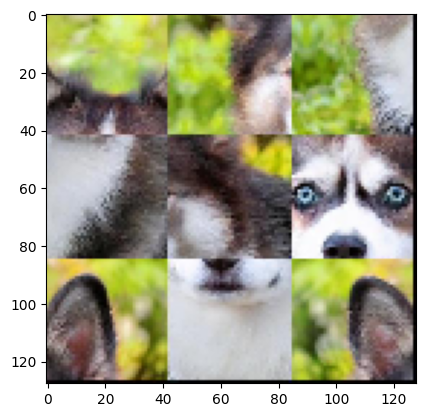

In [ ]:
plt.imshow(image1[0])

In [ ]:
input_shape1 = (128,128,3)
inputs1 = Input(shape=input_shape1)

x = Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu')(inputs1)
x = MaxPooling2D(pool_size=(2,2), strides=2, padding='valid')(x)

x = Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2), strides=2, padding='valid')(x)

x = Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2), strides=2, padding='valid')(x)

x = Flatten()(x)

x = Dense(128, activation='relu')(x)

outputs1=[]
for i in range(num_outputs1):
  outputs1.append(Dense(num_classes1, activation='softmax', name=f'output_{i+1}')(x))

model1 = Model(inputs=inputs1, outputs=outputs1)

model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 126, 126, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 63, 63, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 61, 61, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 30, 30, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 28, 28, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 14, 14, 128)    │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 25088)          │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │      3,211,392 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_1 (Dense)          │ (None, 9)              │          1,161 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_2 (Dense)          │ (None, 9)              │          1,161 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_3 (Dense)          │ (None, 9)              │          1,161 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_4 (Dense)          │ (None, 9)              │          1,161 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_5 (Dense)          │ (None, 9)              │          1,161 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_6 (Dense)          │ (None, 9)              │          1,161 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_7 (Dense)          │ (None, 9)              │          1,161 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_8 (Dense)          │ (None, 9)              │          1,161 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_9 (Dense)          │ (None, 9)              │          1,161 │ dense[0][0]            │
└──────────────────────

 Total params: 3,315,089 (12.65 MB)

 Trainable params: 3,315,089 (12.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model1.compile(
    optimizer='adam',
    loss = ['sparse_categorical_crossentropy']*num_outputs1,
    metrics = ['accuracy']*num_outputs1
)

In [ ]:
callback = EarlyStopping(
    monitor="val_loss",
    min_delta = 0.00001,
    patience = 2,
    verbose = 1,
    mode = 'auto',
    baseline=None,
    restore_best_weights=False,
)

In [ ]:
history1 = model1.fit(
    train_dataset1,
    validation_data=validation_dataset1,
    epochs=10,
    steps_per_epoch=100,
    validation_steps=25,
    callbacks = callback
  )

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2440s 25s/step - loss: 19.8072 - output_1_accuracy: 0.1184 - output_1_loss: 2.2087 - output_2_accuracy: 0.1305 - output_2_loss: 2.1996 - output_3_accuracy: 0.1098 - output_3_loss: 2.2031 - output_4_accuracy: 0.1160 - output_4_loss: 2.2008 - output_5_accuracy: 0.1175 - output_5_loss: 2.2008 - output_6_accuracy: 0.1133 - output_6_loss: 2.2025 - output_7_accuracy: 0.1193 - output_7_loss: 2.1977 - output_8_accuracy: 0.1233 - output_8_loss: 2.1976 - output_9_accuracy: 0.1312 - output_9_loss: 2.1965 - val_loss: 18.7516 - val_output_1_accuracy: 0.2131 - val_output_1_loss: 2.1026 - val_output_2_accuracy: 0.2225 - val_output_2_loss: 2.0958 - val_output_3_accuracy: 0.1919 - val_output_3_loss: 2.1393 - val_output_4_accuracy: 0.1937 - val_output_4_loss: 2.0791 - val_output_5_accuracy: 0.2169 - val_output_5_loss: 2.0694 - val_output_6_accuracy: 0.2313 - val_output_6_loss: 2.0526 - val_output_7_accuracy: 0.2288 - val_output_7_loss: 2.0942 - val_output_8_accura

MODEL PREDICTION AND SCORE CALCULATION

In [ ]:
final_score_animal = dataset_Prediction(
    model1,
    df1,
    100,
    animal_img_path
)

print("Final Score of Model on Animal Dataset is",final_score_animal)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
0.jpg [1, 0, 7, 5, 3, 8, 2, 4, 6] [1 0 7 5 8 8 2 4 6]
0.5555555555555556
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1.jpg [7, 6, 5, 2, 0, 8, 4, 1, 3] [7 6 5 2 0 8 4 2 3]
0.1111111111111111
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━

MODEL EVALUATION

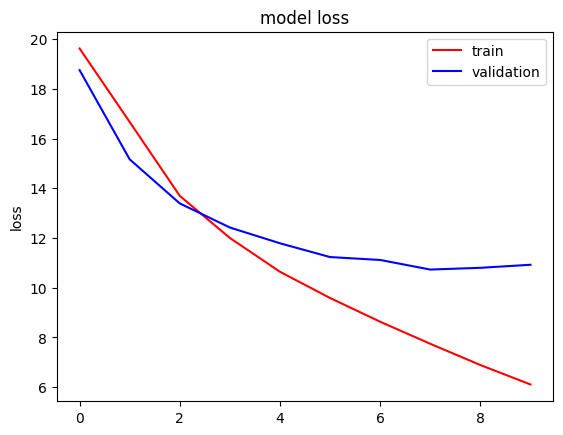

In [ ]:
plot_Loss(history1)

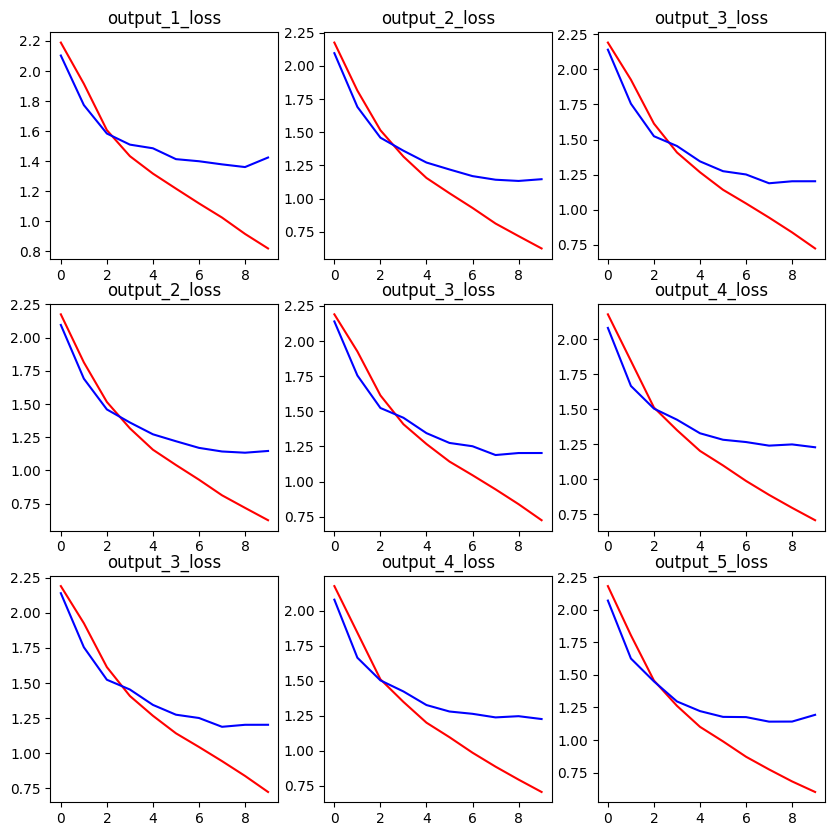

In [ ]:
plot_Individual_Output_Loss(history1,num_outputs1)

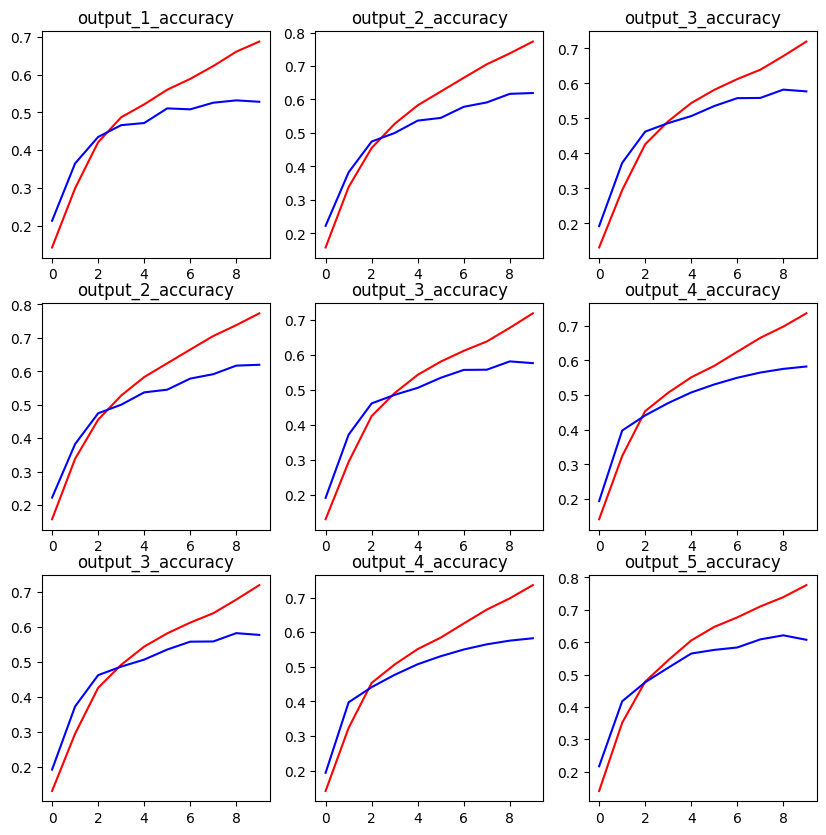

In [ ]:
plot_Individual_Output_Accuracy(history1,num_outputs1)

<h1> TRAINING ON HUMAN DATASET </h1>

In [ ]:
df2 = pd.read_csv(human_csv_path)
df2.head(3)

,image_name,piece_0_0,piece_0_1,piece_0_2,piece_0_3,piece_0_4,piece_1_0,piece_1_1,piece_1_2,piece_1_3,...,piece_3_0,piece_3_1,piece_3_2,piece_3_3,piece_3_4,piece_4_0,piece_4_1,piece_4_2,piece_4_3,piece_4_4
0,0.jpg,"(0, 3)","(0, 2)","(1, 1)","(3, 0)","(2, 1)","(3, 3)","(4, 1)","(2, 3)","(1, 4)",...,"(4, 3)","(0, 1)","(3, 2)","(0, 0)","(4, 4)","(0, 4)","(2, 0)","(1, 3)","(3, 4)","(2, 4)"
1,1.jpg,"(3, 4)","(0, 1)","(0, 3)","(2, 1)","(4, 1)","(1, 0)","(0, 0)","(3, 1)","(4, 3)",...,"(0, 4)","(4, 2)","(2, 4)","(1, 3)","(3, 2)","(4, 4)","(3, 0)","(0, 2)","(2, 3)","(1, 4)"
2,2.jpg,"(4, 4)","(0, 2)","(1, 2)","(0, 4)","(4, 0)","(0, 3)","(3, 1)","(3, 3)","(1, 1)",...,"(3, 4)","(1, 3)","(3, 2)","(0, 1)","(1, 4)","(2, 3)","(4, 3)","(2, 0)","(4, 2)","(3, 0)"


In [ ]:
load_image(df2['image_name'][0],human_img_path).shape

(128, 128, 3)

In [ ]:
for col in df2.keys()[1:]:
  df2[col] = df2[col].map(lambda y: int(y[1])*5+int(y[4]))
df2.head(3)

,image_name,piece_0_0,piece_0_1,piece_0_2,piece_0_3,piece_0_4,piece_1_0,piece_1_1,piece_1_2,piece_1_3,...,piece_3_0,piece_3_1,piece_3_2,piece_3_3,piece_3_4,piece_4_0,piece_4_1,piece_4_2,piece_4_3,piece_4_4
0,0.jpg,3,2,6,15,11,18,21,13,9,...,23,1,17,0,24,4,10,8,19,14
1,1.jpg,19,1,3,11,21,5,0,16,23,...,4,22,14,8,17,24,15,2,13,9
2,2.jpg,24,2,7,4,20,3,16,18,6,...,19,8,17,1,9,13,23,10,22,15


In [ ]:
#Normalize
dataset = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [ ]:
targetColumns2 = list(df2.keys()[1:])
num_outputs2 = len(targetColumns2)
num_classes2 = num_outputs2
targetColumns2

['piece_0_0',
 'piece_0_1',
 'piece_0_2',
 'piece_0_3',
 'piece_0_4',
 'piece_1_0',
 'piece_1_1',
 'piece_1_2',
 'piece_1_3',
 'piece_1_4',
 'piece_2_0',
 'piece_2_1',
 'piece_2_2',
 'piece_2_3',
 'piece_2_4',
 'piece_3_0',
 'piece_3_1',
 'piece_3_2',
 'piece_3_3',
 'piece_3_4',
 'piece_4_0',
 'piece_4_1',
 'piece_4_2',
 'piece_4_3',
 'piece_4_4']

In [ ]:
#human image generators
train_dataset2 = generator_with_tensor_conversion(
    dataset.flow_from_dataframe(
      dataframe = df2,
      directory = human_img_path,
      x_col = "image_name",
      y_col = targetColumns2,
      subset = "training",
      target_size = (128,128),
      batch_size = 64,
      class_mode = "multi_output",
      shuffle = True
  )
)

validation_dataset2 = generator_with_tensor_conversion(
    dataset.flow_from_dataframe(
      dataframe = df2,
      directory = human_img_path,
      x_col = "image_name",
      y_col = targetColumns2,
      subset = "validation",
      target_size = (128,128),
      batch_size = 64,
      class_mode = "multi_output",
      shuffle = False
  )
)

Found 6400 validated image filenames.
Found 1600 validated image filenames.


In [ ]:
image2, label2 = next(train_dataset2)
image2.shape,label2

((64, 128, 128, 3),
 (<tf.Tensor: shape=(64,), dtype=int64, numpy=
  array([24, 15, 16,  5,  4, 21,  1, 12, 16, 11, 12,  8, 15, 17,  6,  2, 15,
         22, 22, 17, 10, 20,  7,  5,  5, 12, 14, 23,  5, 22,  4,  3,  2,  6,
          8,  3,  4, 14,  3, 16, 12,  8, 17, 24,  2, 20, 19,  5,  9, 12, 21,
         21,  3, 16, 18,  3,  2, 16, 18, 18, 12, 19,  9,  1])>,
  <tf.Tensor: shape=(64,), dtype=int64, numpy=
  array([21, 12, 13,  6, 11,  5,  3, 23, 24, 18,  0, 18, 13,  5,  7, 14,  8,
         10,  4,  7,  2,  5, 16,  9, 23,  7, 19, 24, 19, 10,  2, 18, 22, 22,
         10, 10, 20, 12, 21, 24, 21, 15, 19,  2, 15, 24, 13, 19,  2, 14, 15,
         18,  6, 18, 20,  4,  6,  3, 20,  2, 19, 12, 20,  0])>,
  <tf.Tensor: shape=(64,), dtype=int64, numpy=
  array([16,  0, 17,  4, 20,  9, 10, 17, 11, 20, 16,  7, 20, 19, 23, 20, 13,
          5,  0, 15,  7,  2, 20,  1,  3,  5,  9, 13, 16,  1,  9,  9, 14,  2,
         19, 12, 11, 19, 11,  7, 18,  9, 10, 19, 22, 21, 24, 22,  8,  7, 17,
         23,  1, 2

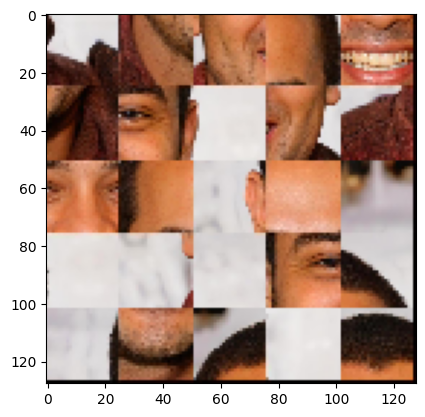

In [ ]:
plt.imshow(image2[0])

In [ ]:
input_shape2 = (128,128,3)
inputs2 = Input(shape=input_shape2)

x = Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu')(inputs2)
x = MaxPooling2D(pool_size=(2,2), strides=2, padding='valid')(x)

x = Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2), strides=2, padding='valid')(x)

x = Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2), strides=2, padding='valid')(x)

x = Flatten()(x)

x = Dense(128, activation='relu')(x)

outputs2=[]
for i in range(num_outputs2):
  outputs2.append(Dense(num_classes2, activation='softmax', name=f'output_{i+1}')(x))

model2 = Model(inputs=inputs2, outputs=outputs2)

model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 126, 126, 32)   │            896 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 63, 63, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 61, 61, 64)     │         18,496 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 30, 30, 64)     │              0 │ conv2d_4[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 28, 28, 128)    │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 14, 14, 128)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 25088)          │              0 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │      3,211,392 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_1 (Dense)          │ (None, 25)             │          3,225 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_2 (Dense)          │ (None, 25)             │          3,225 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_3 (Dense)          │ (None, 25)             │          3,225 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_4 (Dense)          │ (None, 25)             │          3,225 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_5 (Dense)          │ (None, 25)             │          3,225 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_6 (Dense)          │ (None, 25)             │          3,225 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_7 (Dense)          │ (None, 25)             │          3,225 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_8 (Dense)          │ (None, 25)             │          3,225 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_9 (Dense)     

 Total params: 3,385,265 (12.91 MB)

 Trainable params: 3,385,265 (12.91 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model2.compile(
    optimizer='adam',
    loss = ['sparse_categorical_crossentropy']*num_outputs2,
    metrics = ['accuracy']*num_outputs2
)

In [ ]:
callback = EarlyStopping(
    monitor="val_loss",
    min_delta = 0.00001,
    patience = 2,
    verbose = 1,
    mode = 'auto',
    baseline=None,
    restore_best_weights=False,
)

In [ ]:
history2 = model2.fit(
    train_dataset2,
    validation_data=validation_dataset2,
    epochs=10,
    steps_per_epoch=100,
    validation_steps=25,
    callbacks = callback
  )

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2603s 26s/step - loss: 80.7194 - output_10_accuracy: 0.0446 - output_10_loss: 3.2418 - output_11_accuracy: 0.0436 - output_11_loss: 3.2238 - output_12_accuracy: 0.0425 - output_12_loss: 3.2284 - output_13_accuracy: 0.0430 - output_13_loss: 3.2276 - output_14_accuracy: 0.0333 - output_14_loss: 3.2321 - output_15_accuracy: 0.0349 - output_15_loss: 3.2334 - output_16_accuracy: 0.0428 - output_16_loss: 3.2275 - output_17_accuracy: 0.0412 - output_17_loss: 3.2340 - output_18_accuracy: 0.0419 - output_18_loss: 3.2319 - output_19_accuracy: 0.0388 - output_19_loss: 3.2262 - output_1_accuracy: 0.0341 - output_1_loss: 3.2352 - output_20_accuracy: 0.0440 - output_20_loss: 3.2242 - output_21_accuracy: 0.0375 - output_21_loss: 3.2257 - output_22_accuracy: 0.0430 - output_22_loss: 3.2222 - output_23_accuracy: 0.0342 - output_23_loss: 3.2242 - output_24_accuracy: 0.0357 - output_24_loss: 3.2396 - output_25_accuracy: 0.0433 - output_25_loss: 3.2273 - output_2_ac

MODEL PREDICTION AND SCORE CALCULATION

In [ ]:
final_score_human = dataset_Prediction(
    model2,
    df2,
    100,
    human_img_path
)
print("Final Score of Model on Human Dataset is",final_score_human)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
0.jpg [3, 2, 6, 15, 11, 18, 21, 13, 9, 12, 7, 20,

MODEL EVALUATION

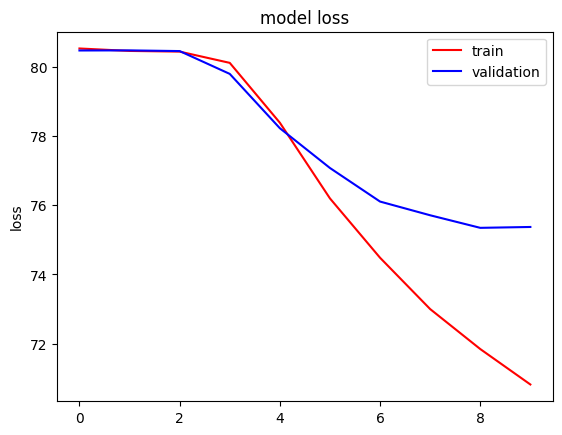

In [ ]:
plot_Loss(history2)

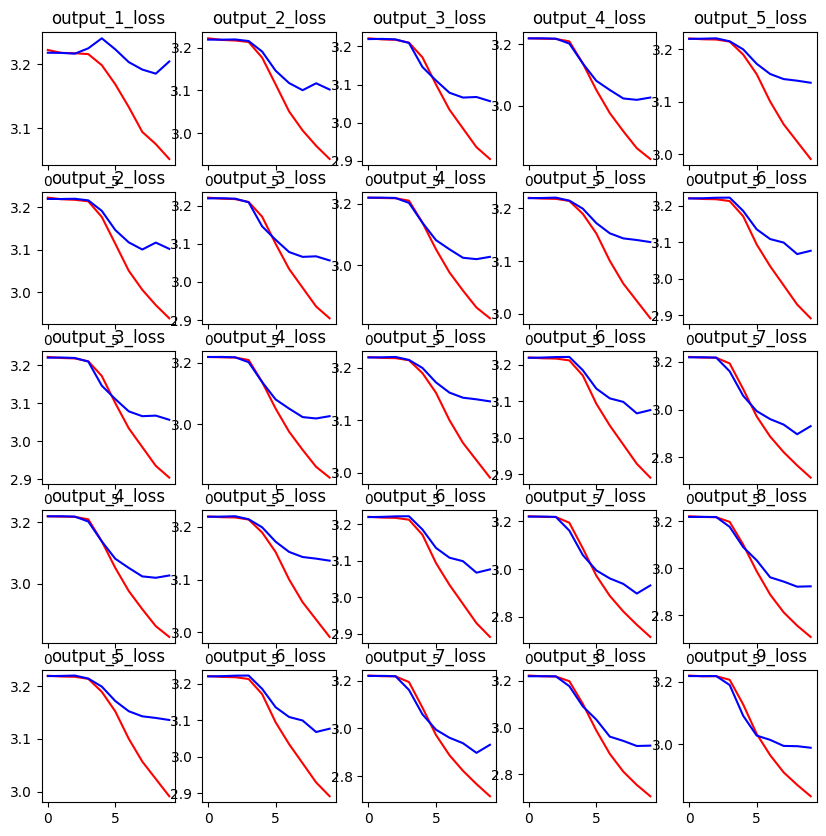

In [ ]:
plot_Individual_Output_Loss(history2,num_outputs2)

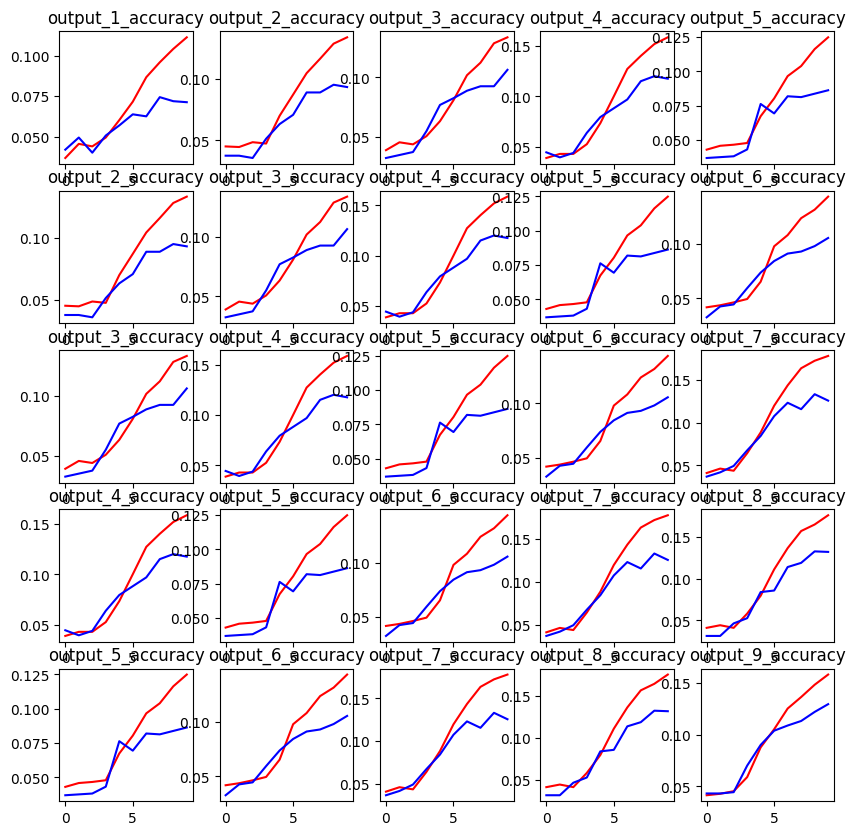

In [ ]:
plot_Individual_Output_Accuracy(history2,num_outputs2)


<H1>FINAL SCORE CALCULATION</H1>

In [ ]:
print("Score of Model on Animal Dataset : ",final_score_animal)
print("Score of Model on Human Dataset : ",final_score_human)
print("Final Weighted Score : ",0.6*final_score_human + 0.4*final_score_animal)

Score of Model on Animal Dataset :  1.3255555555555552
Score of Model on Human Dataset :  6.914399999999998
Final Weighted Score :  4.678862222222221


<H1>TESTING THE MODEL</H1>



*   use model1 for testing of Animal Puzzle
*   List ite



In [ ]:
# testing_Model(model, csv_File_Name, img_File_Directory, output_File_Name)